### Some analysis with Forecastability Measures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # use all for maximum output

from Wind.Results import DBResults, DBMeasures
from Wind.Util.Maps import create_mapbox_plot
from Wind.Private.DBConfig import mapbox_token
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
from Wind.Private.DBConfig import mongolocaltest, mongolocal, mongolocalmeasures
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import pearsonr, kendalltau,spearmanr, normaltest
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.regressor import ResidualsPlot
import sklearn 
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as skl

import sklearn
print(sklearn.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



0.22.1


In [3]:
def create_lat_lon(sites):
   list_sites = sites['site'].tolist()
   latlon_df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/20190823Summary_file.csv')
   df = latlon_df.loc[latlon_df['site_number'].isin(list_sites)]
   return df

In [4]:
df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

In [5]:
df_states.columns

Index(['site_number', 'site', 'seas_index', 'Lon-old', 'Lat-old',
       'Persistence-test', 'Persistence-val', 'MLP_s2s_2-test',
       'MLP_s2s_2-val', 'Lat_trunc', 'Lon_trunc', 'state', 'Lat', 'Lon',
       'JM_CNN_sep_2l_FULL-test', 'JM_CNN_sep_2l_FULL-val', 'MLP_s2s_elu-test',
       'MLP_s2s_elu-val', 'CNN_s2s_elu-test', 'CNN_s2s_elu-val',
       'JM_RF_s2s_2-test', 'JM_RF_s2s_2-val', 'elevation', 'complexity',
       'seasonal', 'residual', 'trend', 'complexity_riley',
       'strength_seasonality', 'strength_trend', 'mean', 'var', 'kurtosis',
       'skew'],
      dtype='object')

In [6]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)

a = results.extract_result(dset='test')
a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

a = a[a[:,0].argsort()] # we sort by first column

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()

b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
b5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
b7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')
b8 = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')

c5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
c6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 
                     'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'state': df_states['state']})

In [7]:

a = a[a[:,0].argsort()] # we sort by first column
a1 = a1[a1[:,0].argsort()] # we sort by first column
a6 = a6[a6[:,0].argsort()] # we sort by first column
a12 = a12[a12[:,0].argsort()] # we sort by first column

predictions = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1],
                     'CNN_sep_2L_1h': a1[:,1], 
                     'CNN_sep_2L_6h': a6[:,1], 'CNN_sep_2L_12h': a12[:,1],
                     'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Stab1w_wind_speed':c5[:,1], 'Lump1w_wind_speed':c6[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 
                     'Season12h_wind_speed':b7[:,1], 'SpecEnt_wind_speed':b8[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'state': df_states['state']})
predictions = predictions.dropna()

scaler = MinMaxScaler((0, 1))
scaler.fit(predictions[['CNN_sep_2L']])
predictions['CNN_sep_2L_sc'] = scaler.transform(predictions[['CNN_sep_2L']])
scaler.fit(predictions[['CNN_sep_2L_1h']])
predictions['CNN_sep_2L_1h_sc'] = scaler.transform(predictions[['CNN_sep_2L_1h']])
scaler.fit(predictions[['CNN_sep_2L_6h']])
predictions['CNN_sep_2L_6h_sc'] = scaler.transform(predictions[['CNN_sep_2L_6h']])
scaler.fit(predictions[['CNN_sep_2L_12h']])
predictions['CNN_sep_2L_12h_sc'] = scaler.transform(predictions[['CNN_sep_2L_12h']])

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
predictions = predictions.dropna()
def correlaciones(predictions, measure):
    print("============")
    print(measure, "classic corr: ", predictions['CNN_sep_2L'].corr(predictions[measure]),
            "R2: ", r2_score(predictions['CNN_sep_2L'], predictions[measure]))
    print(measure, "prediction 1h corr: ", predictions['CNN_sep_2L_1h'].corr(predictions[measure]),"R2: ", 
           r2_score(predictions['CNN_sep_2L_1h'], predictions[measure]))
    print(measure, "prediction 6h corr: ", predictions['CNN_sep_2L_6h'].corr(predictions[measure]),"R2: ", 
           r2_score(predictions['CNN_sep_2L_6h'], predictions[measure]))
    print(measure, "prediction 12h corr: ", predictions['CNN_sep_2L_12h'].corr(predictions[measure]),"R2: ", 
           r2_score(predictions['CNN_sep_2L_12h'], predictions[measure]))
    print("============")
    return

correlaciones(predictions, 'Trend12h_wind_speed')
correlaciones(predictions, 'SpecEnt_wind_speed')
predictions['new_measure'] = - predictions['SpecEnt_wind_speed'] + predictions['Trend12h_wind_speed']
correlaciones(predictions, 'new_measure')

Trend12h_wind_speed classic corr:  0.8339454041567858 R2:  -67.27476685394456
Trend12h_wind_speed prediction 1h corr:  0.9249314399620022 R2:  -3.3262323642878178
Trend12h_wind_speed prediction 6h corr:  0.9049626381141592 R2:  -103.95323714493661
Trend12h_wind_speed prediction 12h corr:  0.8339454041567858 R2:  -67.27476685394456
SpecEnt_wind_speed classic corr:  -0.8308333559942153 R2:  -19.93228140091114
SpecEnt_wind_speed prediction 1h corr:  -0.713447666956205 R2:  -36704.77317999951
SpecEnt_wind_speed prediction 6h corr:  -0.7708689858001161 R2:  -309.8823534148871
SpecEnt_wind_speed prediction 12h corr:  -0.8308333559942153 R2:  -19.93228140091114
new_measure classic corr:  0.853622228000644 R2:  -467.51604203879515
new_measure prediction 1h corr:  0.7527152033535889 R2:  -43811.51886798173
new_measure prediction 6h corr:  0.8043905651338368 R2:  -1590.5965577329023
new_measure prediction 12h corr:  0.853622228000644 R2:  -467.51604203879515


In [9]:
data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
r2_score(data['CNN_sep_2L'],data['Trend12h_wind_speed'])

0.8339406237157402

-67.27487270245624

In [10]:
# ñapa
from sklearn.preprocessing import MinMaxScaler
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation sin scalar',correlation, r2_score(data['CNN_sep_2L'],data['Trend24h_wind_speed']))

scaler = MinMaxScaler((0, 1))
scaler.fit(data[['CNN_sep_2L']])

data['prediction'] = scaler.transform(data[['CNN_sep_2L']])

print('correlation scaled',correlation, r2_score(data['prediction'], data['Trend24h_wind_speed']))

correlation sin scalar 0.8339406237157402 -69.65297103041425


MinMaxScaler(copy=True, feature_range=(0, 1))

correlation scaled 0.8339406237157402 0.5706860674568723


In [11]:
print(data.columns)

Index(['test', 'CNN_sep_2L', 'Trend12h_wind_speed', 'Trend24h_wind_speed',
       'Trend1m_wind_speed', 'Season24h_wind_speed', 'Season1m_wind_speed',
       'Season12h_wind_speed', 'SampEnt_wind_speed', 'state', 'prediction'],
      dtype='object')


In [12]:
data['Trend24h_wind_speed']

0         0.803795
1         0.695409
2         0.665712
3         0.665139
4         0.665125
            ...   
126687    0.705733
126688    0.559848
126689    0.748292
126690    0.699168
126691    0.744178
Name: Trend24h_wind_speed, Length: 126692, dtype: float64

In [13]:
# Table 3
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation FT 12h',correlation, 'R2', r2_score(data['prediction'], data['Trend12h_wind_speed']))

correlation = data['CNN_sep_2L'].corr(data['Trend24h_wind_speed'])
print('correlation FT 24h', correlation, 'R2', r2_score(data['prediction'], data['Trend24h_wind_speed']))

correlation = data['CNN_sep_2L'].corr(data['Trend1m_wind_speed'])
print('correlation FT 1m ',correlation, 'R2', r2_score(data['prediction'], data['Trend1m_wind_speed']))
print('--------------')
correlation = data['CNN_sep_2L'].corr(data['Season12h_wind_speed'])
print('correlation ST 12h',correlation, 'R2', r2_score(data['prediction'], data['Season12h_wind_speed']))
correlation = data['CNN_sep_2L'].corr(data['Season24h_wind_speed'])
print('correlation ST 24h',correlation, 'R2', r2_score(data['prediction'], data['Season24h_wind_speed']))
correlation = data['CNN_sep_2L'].corr(data['Season1m_wind_speed'])
print('correlation ST 1m',correlation, 'R2', r2_score(data['prediction'], data['Season1m_wind_speed']))

correlation FT 12h 0.8339406237157402 R2 -0.48740658989628116
correlation FT 24h 0.8877958718582855 R2 0.5706860674568723
correlation FT 1m  0.4731308595102287 R2 -16.175221564115162
--------------
correlation ST 12h -0.19903601717908878 R2 -9.56696660661943
correlation ST 24h 0.15317702490726845 R2 -5.443003663103811
correlation ST 1m -0.04208742984171607 R2 -8.783007111751374


In [14]:
df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

zs = df[["strength_seasonality"]].to_numpy()
ys = df[["strength_trend"]].to_numpy()

df_tmp = pd.DataFrame({'x':a[:,1], 'trend': ys[:,0], 'season': zs[:,0]})

correlation_trend = pearsonr(a[:,1],ys[:,0])
correlation_season = pearsonr(a[:,1],zs[:,0])
print('correlation seasonal least squares 24h', correlation_season)
print('correlation trend least squares 24h', correlation_trend)

correlation seasonal least squares 24h (0.10995214396437283, 0.0)
correlation trend least squares 24h (0.8414067852374699, 0.0)


In [15]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':b1[:,1], 'Trend12h_wind_speed':b2[:,1], 'Trend1m_wind_speed':b3[:,1]})
correlation = data['CNN_sep_2L'].corr(data['Trend24h_wind_speed'])
print('correlation Trend24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend12h_wind_speed'])
print('correlation Trend12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Trend1m_wind_speed'])
print('correlation Trend1m',correlation)

correlation Trend24h 0.8877958718582855
correlation Trend12h 0.8339406237157402
correlation Trend1m 0.4731308595102287


In [16]:
measure.measures

['SpecEnt',
 'SampEnt',
 'Stab12h',
 'Lump12h',
 'Stab24h',
 'Lump24h',
 'Stab1w',
 'Lump1w',
 'Stab1m',
 'Lump1m',
 'Stab3m',
 'Lump3m',
 'Stab6m',
 'Lump6m',
 'Trend12h',
 'Season12h',
 'Trend24h',
 'Season24h',
 'Trend1m',
 'Season1m']

In [17]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Season24h_wind_speed':b1[:,1], 'Season12h_wind_speed':b2[:,1], 'Season1m_wind_speed':b3[:,1]})
correlation = data['CNN_sep_2L'].corr(data['Season24h_wind_speed'])
print('correlation season24h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season12h_wind_speed'])
print('correlation Season12h',correlation)
correlation = data['CNN_sep_2L'].corr(data['Season1m_wind_speed'])
print('correlation Season1m',correlation)

correlation season24h 0.15317702490726845
correlation Season12h -0.19903601717908878
correlation Season1m -0.04208742984171607


correlation (0.8877958718582878, 0.0)


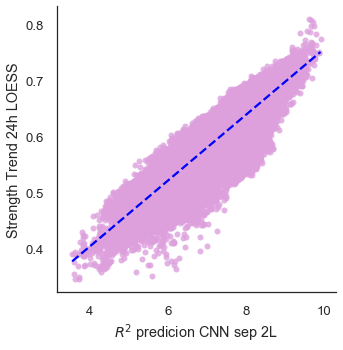

In [18]:
# Strength Trend LOESS
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
df_tmp = pd.DataFrame({'x':a[:,1], 'y': b[:,1]})

correlation = pearsonr(a[:,1], b[:,1])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend 24h LOESS')
#snsplot.set(ylim=(0, None))

snsplot.savefig('e:/figures/Strength_trend_LOESS.png', dpi=300)
snsplot.savefig('e:/figures/Strength_trend_LOESS.pdf')

In [19]:
df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

zs = df[["strength_seasonality"]].to_numpy()
ys = df[["strength_trend"]].to_numpy()

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend_strength_wind_speed':ys[:,0], 'strenght_seasonality_wind_speed':zs[:,0]})
correlation = data['CNN_sep_2L'].corr(data['Trend_strength_wind_speed'])
print('correlation Trend_strength_wind_speed',correlation)

correlation = data['CNN_sep_2L'].corr(data['strenght_seasonality_wind_speed'])
print('strenght_seasonality_wind_speed',correlation)


correlation Trend_strength_wind_speed 0.8414067852374743
strenght_seasonality_wind_speed 0.1099521439643725


correlation (0.8414067852374699, 0.0)


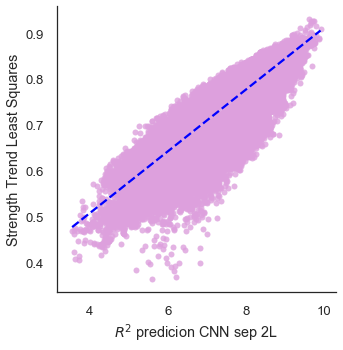

In [20]:
# Grafico de Strenght trend  least squares (como thesis)
import matplotlib.pylab as plt
df_tmp = pd.DataFrame({'x':a[:,1], 'y': ys[:,0]})

correlation = pearsonr(a[:,1],ys[:,0])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})

snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend Least Squares')
snsplot.savefig('e:/figures/Strength_trend_Least_squares.png', dpi=300)

correlation (0.10995214396437283, 0.0) -79.83229830556509


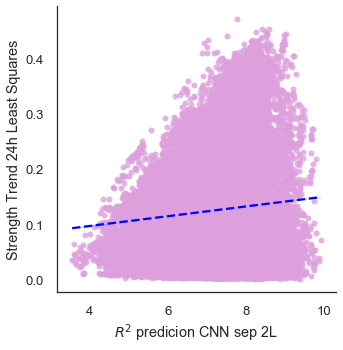

In [21]:
# grafico de Seasonality strhngth 24h least squares

df_tmp = pd.DataFrame({'x':a[:,1], 'y': zs[:,0]})

correlation = pearsonr(a[:,1],zs[:,0])
print('correlation',correlation, r2_score(a[:,1],zs[:,0]))

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Trend 24h Least Squares')
snsplot.savefig('e:/figures/Strength_Seasonal_Least_squares.png', dpi=300)

correlation (0.15317702490727572, 0.0)


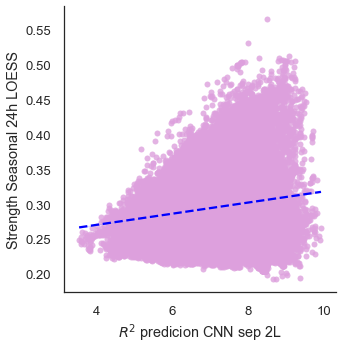

In [22]:
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
df_tmp = pd.DataFrame({'x':a[:,1], 'y': b[:,1]})

correlation = pearsonr(a[:,1],b[:,1])
print('correlation',correlation)

sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "plum"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Strength Seasonal 24h LOESS')
#snsplot.set(ylim=(0, None))

snsplot.savefig('e:/figures/Strength_Seasonal_LOESS.png', dpi=300)

In [23]:
# Creamos dataframe con las dos medidas St_LOESS y St_LSQ
df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')
b1 = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
zs = df_states[["strength_trend"]].to_numpy()

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'St_LOESS':b1[:,1], 'St_LSQ':zs[:,0], 'state': df_states['state']})

In [24]:
data.columns

Index(['test', 'CNN_sep_2L', 'St_LOESS', 'St_LSQ', 'state'], dtype='object')

In [25]:
# correlations between LOESS and ...
df = data

states = ["AL", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", 
          "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "ER"]
# DC, Alaska and Hawaii have no sites (AK, HI, DC)
print('SpecEnt_wind_speed')
for st in states:

    pdX = df[((df['state']==st))  ]
    correlation1 = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
    correlation2 = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
    n = pdX.shape[0]
    print(st,'-', round(correlation1, 3), round(correlation2, 3), 'state_sites', n+1)

SpecEnt_wind_speed
AL - 0.803 0.838 state_sites 89
AZ - 0.783 0.845 state_sites 2376
AR - 0.768 0.808 state_sites 823
CA - 0.837 0.897 state_sites 4053
CO - 0.81 0.851 state_sites 3652
CT - 0.882 0.886 state_sites 156
DE - 0.915 0.899 state_sites 151
FL - 0.726 0.73 state_sites 1040
GA - 0.54 0.485 state_sites 273
ID - 0.835 0.879 state_sites 1451
IL - 0.393 0.555 state_sites 5253
IN - 0.881 0.914 state_sites 3195
IA - 0.639 0.733 state_sites 5253
KS - 0.923 0.935 state_sites 4150
KY - 0.801 0.83 state_sites 347
LA - 0.879 0.879 state_sites 558
ME - 0.907 0.92 state_sites 1201
MD - 0.952 0.963 state_sites 334
MA - 0.914 0.914 state_sites 676
MI - 0.606 0.71 state_sites 3609
MN - 0.81 0.841 state_sites 6372
MS - 0.797 0.876 state_sites 187
MO - 0.816 0.883 state_sites 1836
MT - 0.905 0.924 state_sites 4091
NE - 0.89 0.911 state_sites 3708
NV - 0.795 0.855 state_sites 3865
NH - 0.854 0.876 state_sites 409
NJ - 0.912 0.907 state_sites 483
NM - 0.852 0.885 state_sites 6584
NY - 0.879 0.898

Text(0.5, 0.98, 'Wyoming')

correlation FT LOESS 0.9456901065621138
correlation FT Least Squares 0.9368053949463422


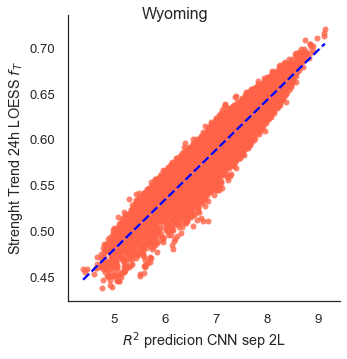

In [26]:
# Mapa de Wyoming
df = data
pdX = df[(df['state']=='WY')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "tomato"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Wyoming", fontsize=16)

snsplot.savefig('e:/figures/F2_Wyoming.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

Text(0.5, 0.98, 'Illinois')

correlation FT LOESS 0.5548201425505271
correlation FT Least Squares 0.392852740693512


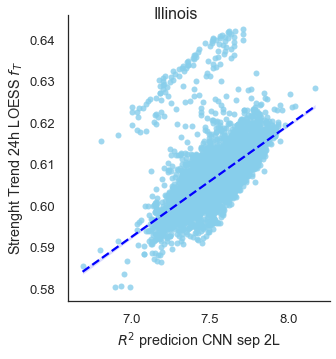

In [27]:
# Mapa de Illinois
df = data
pdX = df[(df['state']=='IL')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Illinois", fontsize=16)

snsplot.savefig('e:/figures/F2_Illinois.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

Text(0.5, 0.98, 'Montana')

correlation FT LOESS 0.923968222866522
correlation FT Least Squares 0.9049892001814254


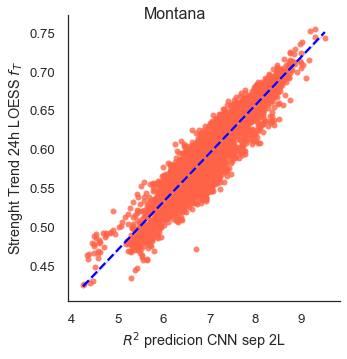

In [28]:
# Mapa de Montana
df = data
pdX = df[(df['state']=='MT')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "tomato"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Montana", fontsize=16)

snsplot.savefig('e:/figures/F2_Montana.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

Text(0.5, 0.98, 'Wisconsin')

correlation FT LOESS 0.6267344560720921
correlation FT Least Squares 0.5001890013181028


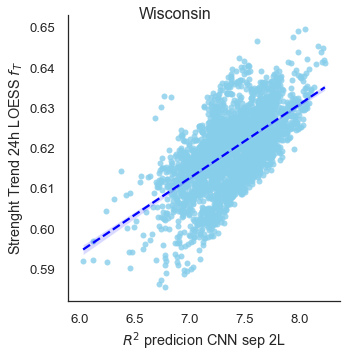

In [29]:
# Mapa de Illiinois
df = data
pdX = df[(df['state']=='WI')]

snsplot = sns.lmplot(x='CNN_sep_2L', y='St_LOESS', palette= sns.color_palette("Reds"),data=pdX, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Strenght Trend 24h LOESS $f_T$')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("Wisconsin", fontsize=16)

snsplot.savefig('e:/figures/F2_Wisconsin.png', dpi=300)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LOESS'])
print('correlation FT LOESS',correlation)

correlation = pdX['CNN_sep_2L'].corr(pdX['St_LSQ'])
print('correlation FT Least Squares',correlation)

### Regressions

#### simple sklearn regression

In [30]:
# 1h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_1h']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

NM  = regr.intercept_ + regr.coef_[0] * predictions['Trend24h_wind_speed'] + regr.coef_[1] * predictions['SpecEnt_wind_speed']

predictions['regression'] = NM
correlaciones(predictions, 'regression')

# 6h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_6h']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

NM  = regr.intercept_ + regr.coef_[0] * predictions['Trend24h_wind_speed'] + regr.coef_[1] * predictions['SpecEnt_wind_speed']

predictions['regression'] = NM
correlaciones(predictions, 'regression')

# 12h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_12h']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

NM  = regr.intercept_ + regr.coef_[0] * predictions['Trend24h_wind_speed'] + regr.coef_[1] * predictions['SpecEnt_wind_speed']

predictions['regression'] = NM
correlaciones(predictions, 'regression')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Intercept: 
 0.3747386905889755
Coefficients: 
 [ 0.84967989 -0.00569453]
regression classic corr:  0.8949525838397815 R2:  -65.10270884628001
regression prediction 1h corr:  0.9064716648941861 R2:  0.8216908792560547
regression prediction 6h corr:  0.9193309765064602 R2:  -98.0419102876163
regression prediction 12h corr:  0.8949525838397815 R2:  -65.10270884628001


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Intercept: 
 2.766569038650628
Coefficients: 
 [ 5.37320309 -0.1432888 ]
regression classic corr:  0.9088937653868413 R2:  -12.303161288724674
regression prediction 1h corr:  0.9033351109771385 R2:  -4814.377599985634
regression prediction 6h corr:  0.922523071157045 R2:  0.8510488168170144
regression prediction 12h corr:  0.9088937653868413 R2:  -12.303161288724674


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Intercept: 
 9.357093468118451
Coefficients: 
 [ 9.1568999 -0.6952496]
regression classic corr:  0.9181285178118812 R2:  0.8429599752194894
regression prediction 1h corr:  0.8835899799823167 R2:  -15684.979613370175
regression prediction 6h corr:  0.9132441172815373 R2:  -63.368784203564104
regression prediction 12h corr:  0.9181285178118812 R2:  0.8429599752194894


### Statsmodel Regression

In [31]:
# 1h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_1h']

X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
pred = model.predict(X)
predictions['regression'] = pred
correlaciones(predictions, 'regression')

# 6h ahead
Y = predictions['CNN_sep_2L_6h']
X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
pred = model.predict(X)
predictions['regression'] = pred
correlaciones(predictions, 'regression')

#12h ahead
Y = predictions['CNN_sep_2L_12h']
X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
pred = model.predict(X)
predictions['regression'] = pred
correlaciones(predictions, 'regression')


regression classic corr:  0.894952583839772 R2:  -65.10270884627968
regression prediction 1h corr:  0.9064716648941878 R2:  0.8216908792560547
regression prediction 6h corr:  0.9193309765064603 R2:  -98.04191028761548
regression prediction 12h corr:  0.894952583839772 R2:  -65.10270884627968
regression classic corr:  0.9088937653868366 R2:  -12.30316128872983
regression prediction 1h corr:  0.9033351109771425 R2:  -4814.377599984102
regression prediction 6h corr:  0.922523071157048 R2:  0.8510488168170144
regression prediction 12h corr:  0.9088937653868366 R2:  -12.30316128872983
regression classic corr:  0.918128517811879 R2:  0.8429599752194894
regression prediction 1h corr:  0.8835899799823262 R2:  -15684.979613376687
regression prediction 6h corr:  0.913244117281543 R2:  -63.368784203623434
regression prediction 12h corr:  0.918128517811879 R2:  0.8429599752194894


### LASSO Regression

In [32]:
# 1h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_1h']

model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')

# 6h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_6h']

model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')

# 12h ahead
X = predictions[['Trend24h_wind_speed', 'SpecEnt_wind_speed']]
Y = predictions['CNN_sep_2L_12h']

model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')



Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 0.0835211  -0.07450605] 1.5759241419641001 21
R2 0.5653915298746153
ojo 0.5653915298746153
lasso classic corr:  0.8600786172715528 R2:  -65.13158963574529
lasso prediction 1h corr:  0.7569021109074925 R2:  0.5653915298746153
lasso prediction 6h corr:  0.8098313847657624 R2:  -98.11754127718413
lasso prediction 12h corr:  0.8600786172715528 R2:  -65.13158963574529


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 4.60747385 -0.21205859] 3.967046981528919 16
R2 0.8457908792667107
ojo 0.8457908792667107
lasso classic corr:  0.915383828950916 R2:  -12.317630443382726
lasso prediction 1h corr:  0.8965858861788769 R2:  -4811.209046602565
lasso prediction 6h corr:  0.9205982732546409 R2:  0.8457908792667107
lasso prediction 12h corr:  0.915383828950916 R2:  -12.317630443382726


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 8.39166238 -0.76397162] 10.556761510799607 17
R2 0.8418850198217691
ojo 0.8418850198217691
lasso classic corr:  0.9176766960247021 R2:  0.8418850198217691
lasso prediction 1h corr:  0.8768066509643178 R2:  -15678.628661256094
lasso prediction 6h corr:  0.9087006626064814 R2:  -63.3086435259698
lasso prediction 12h corr:  0.9176766960247021 R2:  0.8418850198217691


### LASSO ALL

In [33]:
#1h ahead
Y = predictions['CNN_sep_2L_1h']
X = predictions[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')

#6h ahead
Y = predictions['CNN_sep_2L_6h']
X = predictions[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')

#12h ahead
Y = predictions['CNN_sep_2L_12h']
X = predictions[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(Y,NM1))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 0.         -0.         -0.12061825 -0.0729688  -0.01030627 -0.01977899
  0.         -0.        ] 1.7395379152538546 32
R2 0.6607456633287783
ojo 0.6607456633287783
lasso classic corr:  0.8920483277187491 R2:  -65.12504428220271
lasso prediction 1h corr:  0.8211933249003697 R2:  0.6607456633287783
lasso prediction 6h corr:  0.8633017107138486 R2:  -98.09975646480197
lasso prediction 12h corr:  0.8920483277187491 R2:  -65.12504428220271


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 2.12495805  0.         -0.54155041 -0.3096844  -0.10592761 -0.14396476
  1.98577939 -0.        ] 5.812833662146353 152
R2 0.8940106588174548
ojo 0.8940106588174548
lasso classic corr:  0.9215002135467364 R2:  -12.301634564404372
lasso prediction 1h corr:  0.9321626106945157 R2:  -4812.522975369541
lasso prediction 6h corr:  0.9465238784829223 R2:  0.8940106588174548
lasso prediction 12h corr:  0.9215002135467364 R2:  -12.301634564404372


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 8.47561352  2.18269303 -0.68199997 -0.68860686 -0.13378298  0.
  0.         -0.        ] 9.817755166384512 45
R2 0.8801513043126483
ojo 0.8801513043126483
lasso classic corr:  0.9383866753016524 R2:  0.8801513043126483
lasso prediction 1h corr:  0.9034192485294326 R2:  -15684.339155858022
lasso prediction 6h corr:  0.9343212362238358 R2:  -63.282308232564645
lasso prediction 12h corr:  0.9383866753016524 R2:  0.8801513043126483


In [34]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a=results.extract_result(dset='test')

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()
a = a[a[:,0].argsort()] # we sort by first column

# Use Sampent and TrendLoess
b = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c = measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')

Text(0.5, 1.0, 'Strength Trend 24h vs SpectEnt')

Text(0.5, 0, 'Strength Trend 24h')

Text(0, 0.5, 'SpecEnt')

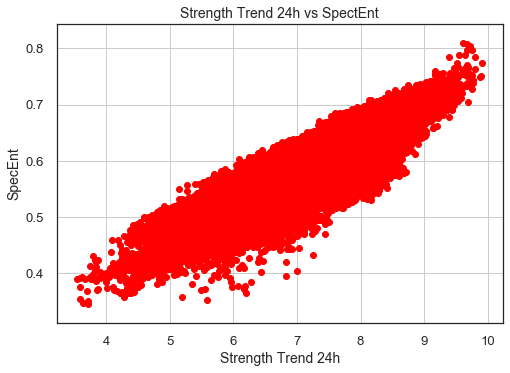

In [35]:
# obtaining correlations linear regression

df_multi = pd.DataFrame({'x':a[:,1], 'y': b[:,1], 'z' : c[:,1]})

plt.scatter(df_multi['x'], df_multi['y'], color='red')
plt.title('Strength Trend 24h vs SpectEnt', fontsize=14)
plt.xlabel('Strength Trend 24h', fontsize=14)
plt.ylabel('SpecEnt', fontsize=14)
plt.grid(True)
plt.show()

In [36]:
# por alguna razon oscura SpecEnt tiene 15 o 20 nulls
# hacemos una ñapa y eliminamos las filas
tmp = df_multi['z'].notnull()
df_multi1 = df_multi[tmp]

### Sklearn linear regression

In [37]:
from sklearn import linear_model
import statsmodels.api as skl

X = df_multi1[['y', 'z']]
Y = df_multi1['x']

In [38]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Intercept: 
 9.357093468118451
Coefficients: 
 [ 9.1568999 -0.6952496]


In [39]:
# new measure

NM  = regr.intercept_ + regr.coef_[0] * df_multi1['y'] + regr.coef_[1] * df_multi1['z']

In [40]:
correlation = df_multi1['x'].corr(NM)
correlation1 = df_multi1['x'].corr(df_multi1['y'])
correlation2 = df_multi1['x'].corr(df_multi1['z'])
print('correlation x - NM :',correlation, r2_score(df_multi1['x'],NM))
print('correlation x - y  :', correlation1, r2_score(df_multi1['y'],NM))
print('correlation x - z  :', correlation2, r2_score(df_multi1['z'],NM))
predictions['regression'] = NM
correlaciones(predictions, 'regression')

correlation x - NM : 0.9181285178118812 0.8429599752194894
correlation x - y  : 0.8877898705192981 -15967.317297502066
correlation x - z  : -0.8308333559942153 -74.59663229669897
regression classic corr:  0.9181285178118812 R2:  0.8429599752194894
regression prediction 1h corr:  0.8835899799823167 R2:  -15684.979613370175
regression prediction 6h corr:  0.9132441172815373 R2:  -63.368784203564104
regression prediction 12h corr:  0.9181285178118812 R2:  0.8429599752194894


In [41]:
print(df_multi1['y'], NM) # para calcular bien el R2 hay que scalar el resultado entre 0 y 1?

0         0.803795
1         0.695409
2         0.665712
3         0.665139
4         0.665125
            ...   
126687    0.705733
126688    0.559848
126689    0.748292
126690    0.699168
126691    0.744178
Name: y, Length: 126661, dtype: float64 0         10.070698
1          8.655822
2          8.097642
3          8.098488
4          8.102194
            ...    
126687     8.811938
126688     6.889725
126689     9.231661
126690     8.751746
126691     9.198175
Length: 126661, dtype: float64


Text(0.5, 0.98, 'Linear Regression')

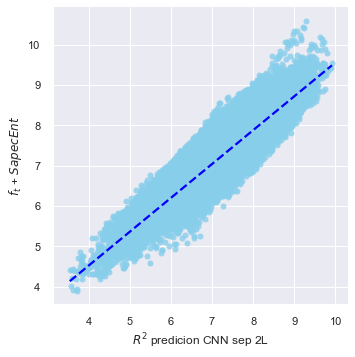

In [42]:
fig = snsplot.fig 
sns.set(font_scale=1.2)
sns.set_style(style='white')
sns.set(rc={'figure.figsize':(12,12)})
df_NM = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM.values})
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=df_NM, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','$f_t$ + $SapecEnt$')
fig.suptitle("Linear Regression", fontsize=16)
snsplot.savefig('e:/figures/regression_1(loess).png', dpi=300)

[Text(0, 0.5, '$f_t$ + $SapecEnt$'),
 Text(0.5, 0, '$R^2$ predicion CNN sep 2L'),
 Text(0.5, 1.0, 'Linear Regression LOESS')]

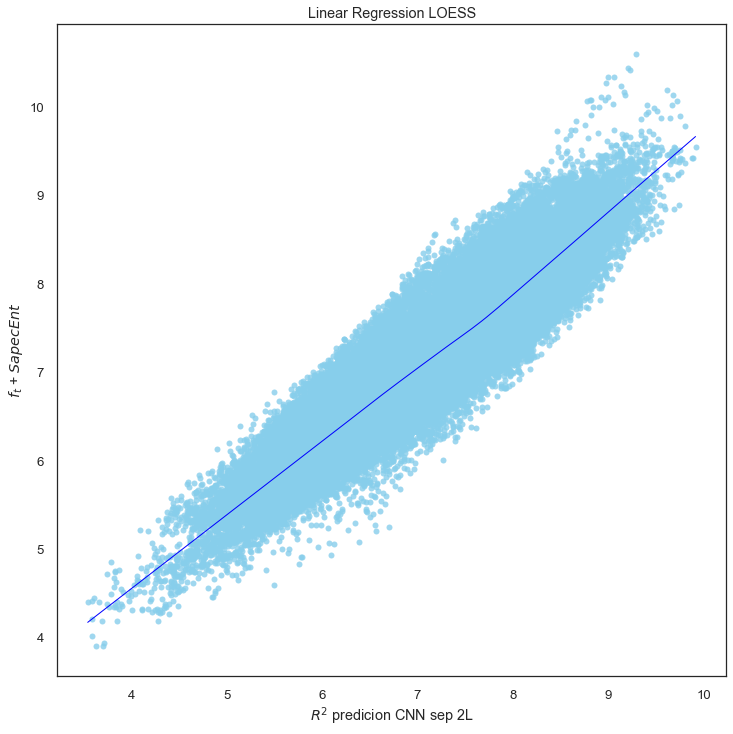

In [43]:
sns.set(rc={'figure.figsize':(12,12)})

df_NMa = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM.values})
sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.regplot(x='CNN_sep_2L', y='New Measure', data=df_NMa, 
                     scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "lw":1}, lowess=True)

snsplot.set(xlabel='$R^2$ predicion CNN sep 2L', ylabel='$f_t$ + $SapecEnt$',title = "Linear Regression LOESS")


snsplot.figure.savefig('e:/figures/regression_loess(with_lowess).png', dpi=300)



### Statsmodel linear regression

In [44]:
X = skl.add_constant(X)
model = skl.OLS(Y, X).fit()
residuals = model.resid
prediccion = model.predict(X)

In [45]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 3.399e+05
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:15:58   Log-Likelihood:                -34925.
No. Observations:              126661   AIC:                         6.986e+04
Df Residuals:                  126658   BIC:                         6.989e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3571      0.049    192.016      0.0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


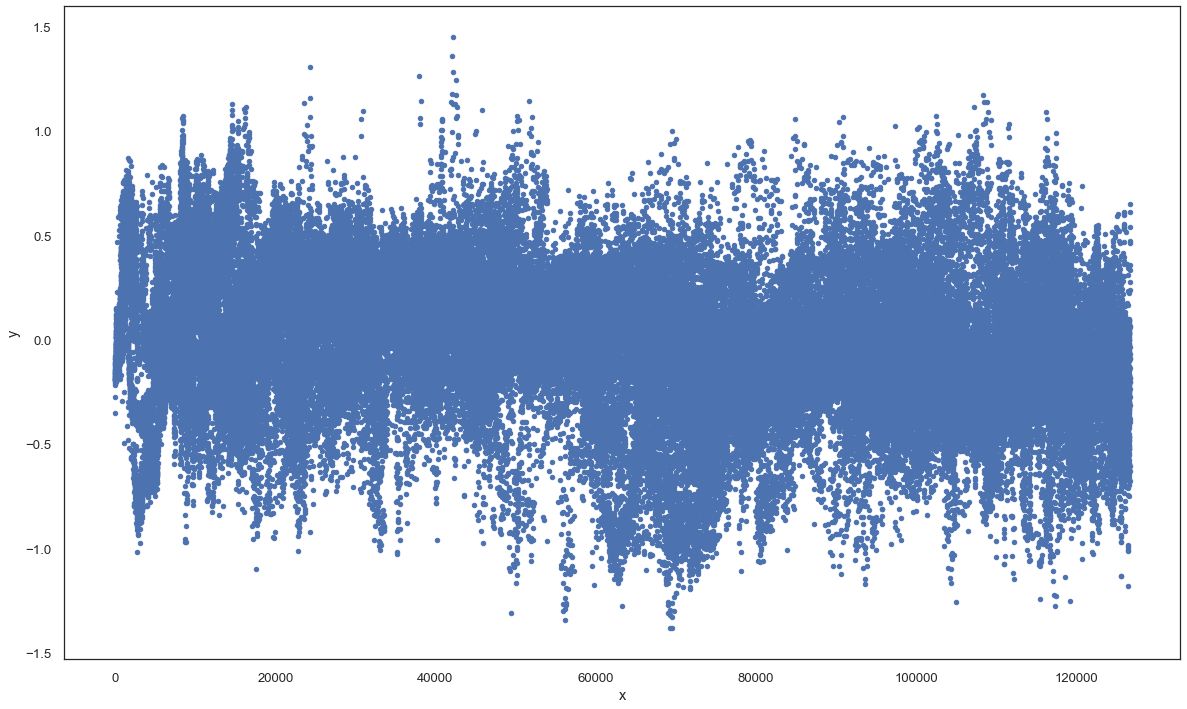

In [46]:
plt.rcParams['figure.figsize'] = (20.0, 12.0)
df = residuals.to_frame()
df = df.rename(columns={0: "y"})
df['x'] = df.index
df.plot(x='x',y='y',kind='scatter')

In [47]:
# are residuals normal?
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=2533.179, p=0.000
Sample does not look Gaussian (reject H0)


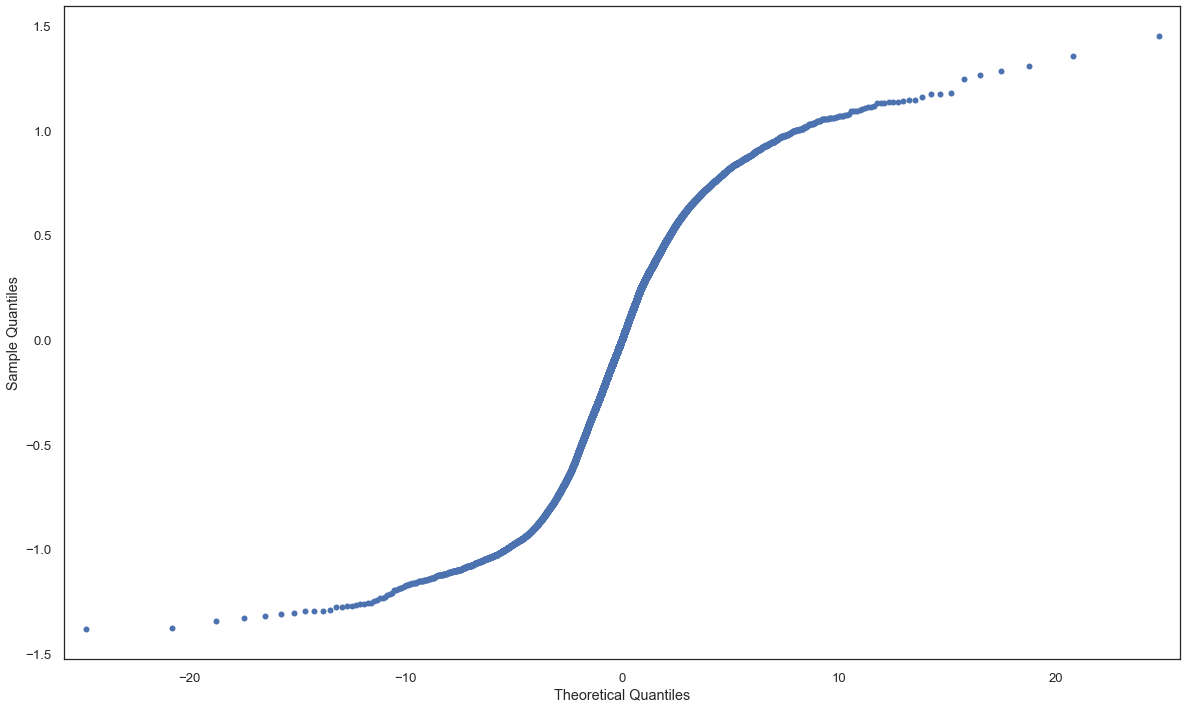

In [48]:
# lets plot the residuals
fig = skl.qqplot(residuals, stats.t, distargs=(4,))
plt.show()

### Now with LASSO Regression

In [49]:
import sklearn 
from sklearn.linear_model import Lasso
from yellowbrick.regressor import ResidualsPlot

X = df_multi1[['y', 'z']]
Y = df_multi1['x']

#y = df_multi1['x'].to_numpy()

#y.reshape(-1, 1)

model_lasso = Lasso(alpha=0.001, max_iter=10000)

In [50]:
print(NM1.shape)
print(X.shape)

(126661,)
(126661, 2)


In [51]:
predictions.columns

Index(['test', 'CNN_sep_2L', 'CNN_sep_2L_1h', 'CNN_sep_2L_6h',
       'CNN_sep_2L_12h', 'Trend12h_wind_speed', 'Trend24h_wind_speed',
       'Trend1m_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed',
       'Season24h_wind_speed', 'Season1m_wind_speed', 'Season12h_wind_speed',
       'SpecEnt_wind_speed', 'SampEnt_wind_speed', 'state', 'CNN_sep_2L_sc',
       'CNN_sep_2L_1h_sc', 'CNN_sep_2L_6h_sc', 'CNN_sep_2L_12h_sc',
       'new_measure', 'regression', 'lasso'],
      dtype='object')

In [52]:
model_lasso.fit(X,Y)
print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM1 = model_lasso.predict(X)
print('R2', model_lasso.score(X,Y))
print('ojo',r2_score(NM1, Y))
predictions['lasso'] = NM1
correlaciones(predictions, 'lasso')

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 8.39166238 -0.76397162] 10.556761510799607 17
R2 0.8418850198217691
ojo 0.8056645861892857
lasso classic corr:  0.9176766960247021 R2:  0.8418850198217691
lasso prediction 1h corr:  0.8768066509643178 R2:  -15678.628661256094
lasso prediction 6h corr:  0.9087006626064814 R2:  -63.3086435259698
lasso prediction 12h corr:  0.9176766960247021 R2:  0.8418850198217691


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7F880B588>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

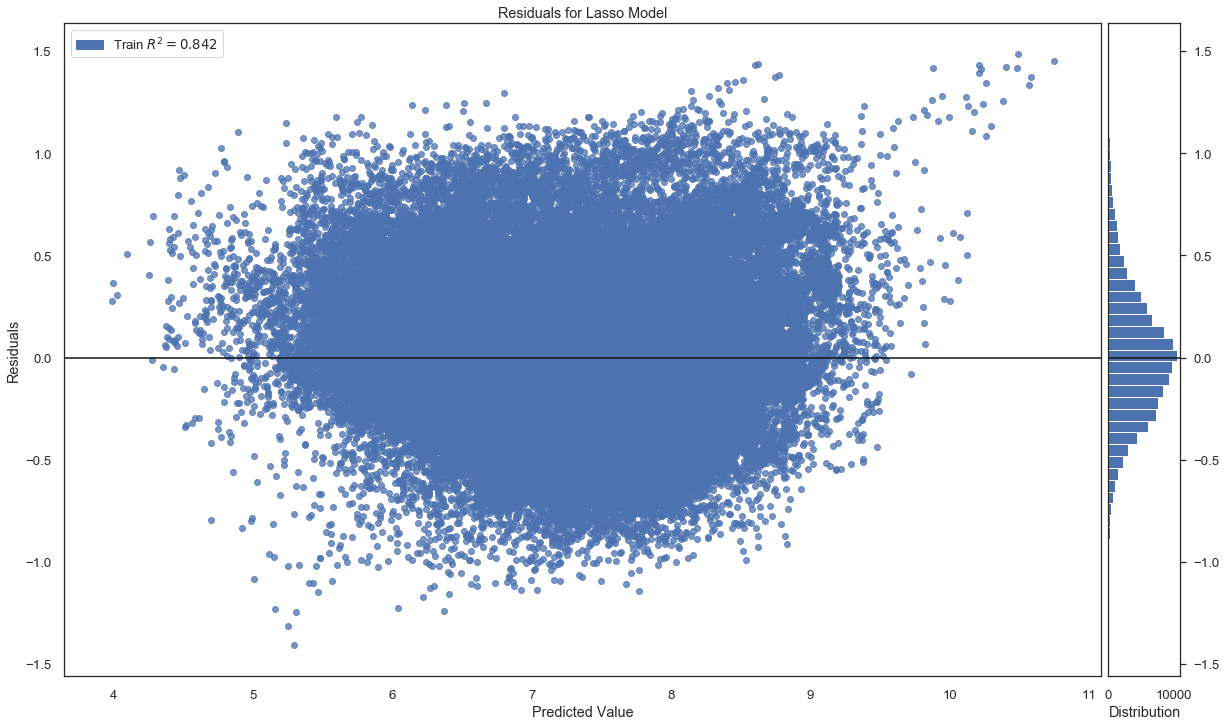

In [53]:
visualizer = ResidualsPlot(model_lasso)
visualizer.fit(X,Y)  # Fit the training data to the visualizer
#visualizer.score(X,Y)  # Evaluate the model on the test data
visualizer.show() 

In [54]:
df_NM2 = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM1})

correlation = df_multi1['x'].corr(df_NM2['New Measure'])
print(correlation)

0.9176766960247021


Text(0.5, 0.98, 'LASSO linear regression')

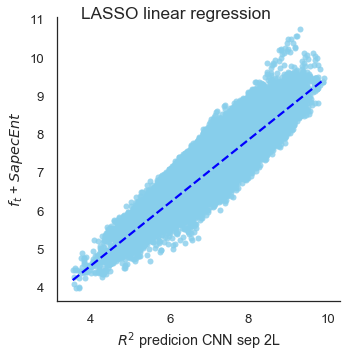

In [55]:
df_NM1 = pd.DataFrame({'CNN_sep_2L': df_multi1.x, 'New Measure': NM1})
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.2)
sns.set_style(style='white')
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=df_NM1, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})

snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','$f_t$ + $SapecEnt$')
snsplot.fig.suptitle('LASSO linear regression')
snsplot.savefig('e:/figures/regression_LASSO.png', dpi=300)

In [56]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
# https://medium.com/@23.sargam/lasso-regression-for-feature-selection-8ac2287e25fa

### Lasso Linear Regression with selected measures

In [57]:
measure.measures

['SpecEnt',
 'SampEnt',
 'Stab12h',
 'Lump12h',
 'Stab24h',
 'Lump24h',
 'Stab1w',
 'Lump1w',
 'Stab1m',
 'Lump1m',
 'Stab3m',
 'Lump3m',
 'Stab6m',
 'Lump6m',
 'Trend12h',
 'Season12h',
 'Trend24h',
 'Season24h',
 'Trend1m',
 'Season1m']

In [58]:
c1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
c3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
c4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
c5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
c6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')
c7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
c8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':c1[:,1], 'Season24h_wind_speed':c2[:,1], 
                     'SampEnt_wind_speed':c3[:,1], 'SpecEnt_wind_speed':c4[:,1], 'Stab1w_wind_speed':c5[:,1],
                    'Lump1w_wind_speed':c6[:,1],
                     'Trend12h_wind_speed':c7[:,1], 'Season12h_wind_speed':c8[:,1],
                    })
data = data.dropna()

In [59]:
Y = data['CNN_sep_2L']
X = data[['Trend24h_wind_speed', 'Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed', 'Season12h_wind_speed']]


In [60]:
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X,Y)

print(model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
NM2 = model_lasso.predict(X)
print('R2',model_lasso.score(X,Y))

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[ 8.47561352  2.18269303 -0.68199997 -0.68860686 -0.13378298  0.
  0.         -0.        ] 9.817755166384512 45
R2 0.8801513043126483


In [61]:
df_NM2 = pd.DataFrame({'CNN_sep_2L': data.CNN_sep_2L, 'New Measure': NM2})

correlation = df_NM2['CNN_sep_2L'].corr(df_NM2['New Measure'])
print(correlation)

0.9383866753016524


Text(0.5, 0.98, 'LASSO feature selection ')

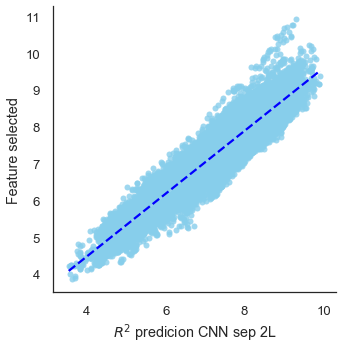

In [62]:
fig = snsplot.fig 
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig.suptitle("LASSO feature selection ", fontsize=16)
snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=df_NM2, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','Feature selected')
snsplot.savefig('e:/figures/regression_feature_selection_LASSO.png', dpi=300)

### Testing if the distributions are normal

In [63]:
# D’Agostino’s K^2 Test

data = a[:,1]
data = c1[:,1]

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=5303.489, p=0.000
Sample does not look Gaussian (reject H0)


In [64]:
# anderson darling
from scipy.stats import anderson
# normality test
data = c1[:,1]
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
   sl, cv = result.significance_level[i], result.critical_values[i]
   if result.statistic < result.critical_values[i]:
      print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
   else:
      print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 847.147
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [65]:
#kolmogorov smirnoff
from scipy.stats import kstest
data = c1[:,1]
data = np.random.normal(0, 1, 100000)
kstest(data, 'norm')


KstestResult(statistic=0.0019814907211493926, pvalue=0.8272240121834106)

In [66]:
# shapiro - wilcox
from scipy.stats import shapiro
data = c1[:,1]
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.981, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



Text(0.5, 1.0, 'CNN 2L prediction')

Text(0.5, 1.0, 'Season 24h')

Text(0.5, 1.0, 'Trend24h')

Text(0.5, 1.0, 'SampEnt')

Text(0.5, 1.0, 'SpecEnt')

Text(0.5, 1.0, 'Stab1w')

Text(0.5, 1.0, 'Lump1w')

Text(0.5, 1.0, 'Trend12h')

Text(0.5, 1.0, 'Season12h')

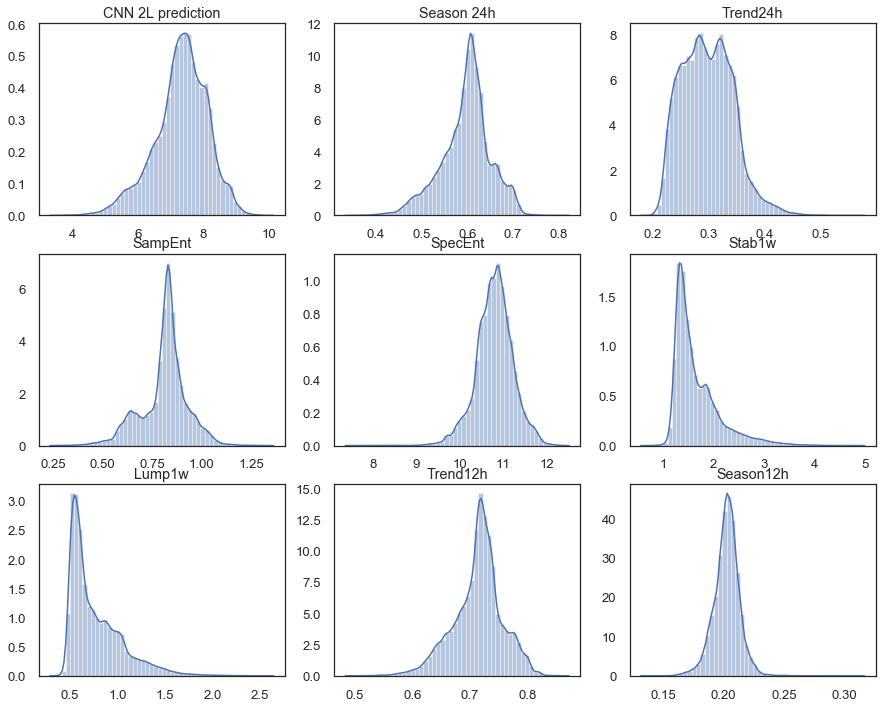

In [67]:
# dibujamos las distribuciones toas toas
plt.rcParams['figure.figsize'] = (15.0, 12.0)
f, axes = plt.subplots(3,3)
sns.distplot(a[:,1], label='CNN 2L prediction', kde=True, norm_hist=True, ax=axes[0,0]).set_title('CNN 2L prediction')
sns.distplot(c1[:,1], label='Season 24h', kde=True, norm_hist=True, ax=axes[0,1]).set_title('Season 24h')
sns.distplot(c2[:,1], label='Trend 24h', kde=True, norm_hist=True, ax=axes[0,2]).set_title('Trend24h')
sns.distplot(c3[:,1], label='SampEnt', kde=True, norm_hist=True, ax=axes[1,0]).set_title('SampEnt')
sns.distplot(c4[:,1], label='SpecEnt', kde=True, norm_hist=True, ax=axes[1,1]).set_title('SpecEnt')
sns.distplot(c5[:,1], label='Stab1w', kde=True, norm_hist=True, ax=axes[1,2]).set_title('Stab1w')
sns.distplot(c6[:,1], label='Lump1w', kde=True, norm_hist=True, ax=axes[2,0]).set_title('Lump1w')
sns.distplot(c7[:,1], label='Trend12h', kde=True, norm_hist=True, ax=axes[2,1]).set_title('Trend12h')
sns.distplot(c8[:,1], label='Season12h', kde=True, norm_hist=True, ax=axes[2,2]).set_title('Season12h')

### A Feature selection try with Lasso

In [68]:
c1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
c2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
c3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
c4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
c5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
c6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')
c7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
c8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season12h')

data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L': a[:,1], 'Trend24h_wind_speed':c1[:,1], 'Season24h_wind_speed':c2[:,1], 
                     'SampEnt_wind_speed':c3[:,1], 'SpecEnt_wind_speed':c4[:,1], 'Stab1w_wind_speed':c5[:,1],
                    'Lump1w_wind_speed':c6[:,1],
                     'Trend12h_wind_speed':c7[:,1], 'Season12h_wind_speed':c8[:,1],
                    })
data = data.dropna()
data = data.dropna()
Y = data['CNN_sep_2L']
X = data[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]


<Figure size 864x720 with 0 Axes>

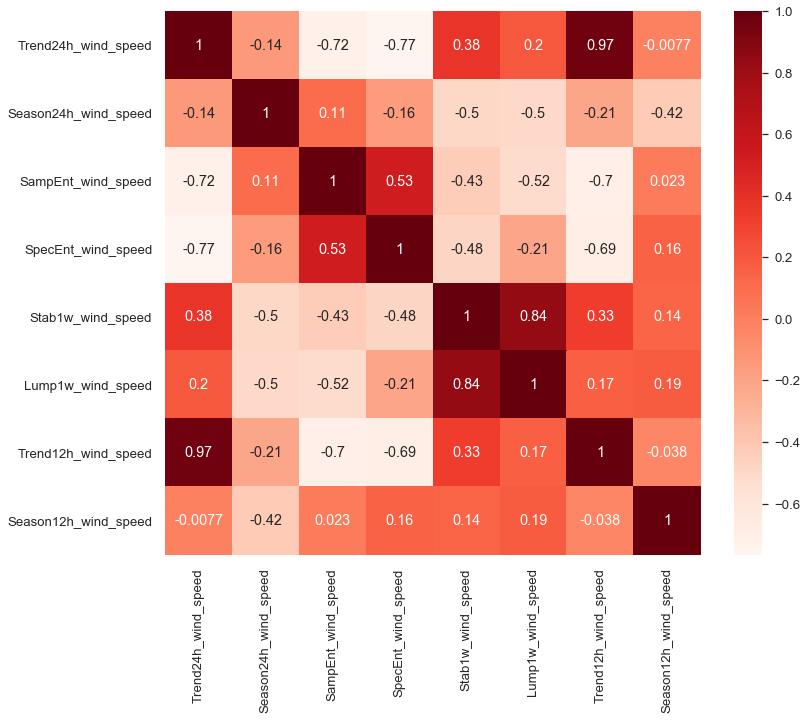

In [69]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [70]:
#lfs = lasso feature selection
lfs = LassoCV()
lfs.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % lfs.alpha_)
print("Best score using built-in LassoCV: %f" % lfs.score(X,Y))
coef = pd.Series(lfs.coef_, index = X.columns)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Best alpha using built-in LassoCV: 0.000282
Best score using built-in LassoCV: 0.889472


In [71]:
print(coef)

Trend24h_wind_speed     10.350430
Season24h_wind_speed     3.341667
SampEnt_wind_speed      -0.303035
SpecEnt_wind_speed      -0.493277
Stab1w_wind_speed       -0.086388
Lump1w_wind_speed        0.122693
Trend12h_wind_speed      0.000000
Season12h_wind_speed    -3.192061
dtype: float64


In [72]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 1 variables


valores Season12h_wind_speed    -3.192061
SpecEnt_wind_speed      -0.493277
SampEnt_wind_speed      -0.303035
Stab1w_wind_speed       -0.086388
Trend12h_wind_speed      0.000000
Lump1w_wind_speed        0.122693
Season24h_wind_speed     3.341667
Trend24h_wind_speed     10.350430
dtype: float64


Text(0.5, 1.0, 'Feature importance using Lasso Model')

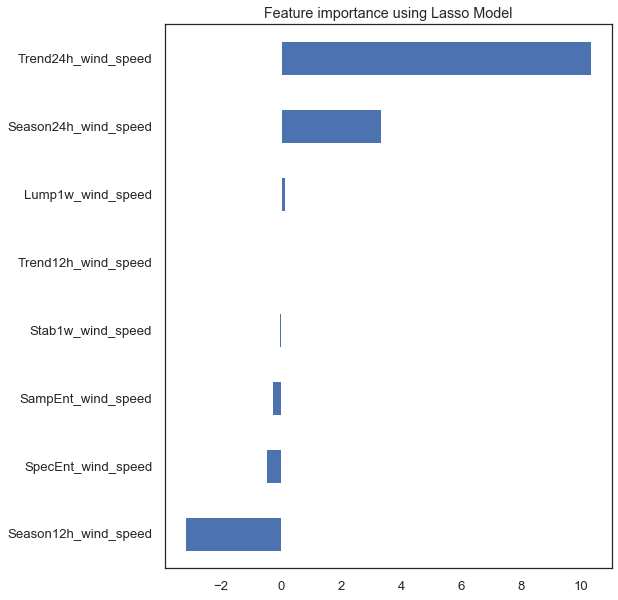

In [73]:
imp_coef = coef.sort_values()
print('valores', imp_coef)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [74]:
model_columns = [['Trend24h_wind_speed','Season24h_wind_speed', 'SampEnt_wind_speed', 
                  'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed',
                   'Trend12h_wind_speed','Season12h_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed', 'SampEnt_wind_speed', 
                  'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed',
                  'Season12h_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed', 'SampEnt_wind_speed', 
                  'SpecEnt_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed'],
                 ['SampEnt_wind_speed', 
                  'SpecEnt_wind_speed'],
                 ['Trend24h_wind_speed','Season24h_wind_speed','SampEnt_wind_speed', 'Lump1w_wind_speed'],
                ]

In [75]:
model_columns[1]
model_lasso = Lasso(alpha=0.001, max_iter=10000)
for cols in model_columns:
    X = data[cols]
    model_lasso.fit(X,Y)
#    print('(1)', model_lasso.coef_, model_lasso.intercept_, model_lasso.n_iter_)
    NM2 = model_lasso.predict(X)
    df_NM2 = pd.DataFrame({'CNN_sep_2L': data.CNN_sep_2L, 'New Measure': NM2})
    correlation = df_NM2['CNN_sep_2L'].corr(df_NM2['New Measure'])
    print(cols)
    print('   ', X.shape, 'correlation :', correlation, 'R2 : ', model_lasso.score(X,Y))

['Trend24h_wind_speed',
 'Season24h_wind_speed',
 'SampEnt_wind_speed',
 'SpecEnt_wind_speed',
 'Stab1w_wind_speed',
 'Lump1w_wind_speed',
 'Season12h_wind_speed']

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed', 'Trend12h_wind_speed', 'Season12h_wind_speed']
    (126661, 8) correlation : 0.9383866753016524 R2 :  0.8801513043126483


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed', 'Lump1w_wind_speed', 'Season12h_wind_speed']
    (126661, 7) correlation : 0.9383866582073824 R2 :  0.8801512711343963


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'SpecEnt_wind_speed']
    (126661, 4) correlation : 0.9395930910354847 R2 :  0.8823235693196008


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

['Trend24h_wind_speed', 'Season24h_wind_speed']
    (126661, 2) correlation : 0.931142210049236 R2 :  0.8660613598212707


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

['SampEnt_wind_speed', 'SpecEnt_wind_speed']
    (126661, 2) correlation : 0.8694881973336672 R2 :  0.7559746906965019


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

['Trend24h_wind_speed', 'Season24h_wind_speed', 'SampEnt_wind_speed', 'Lump1w_wind_speed']
    (126661, 4) correlation : 0.934658791685293 R2 :  0.8725477348856484


### NON-linear model (SVM)

In [76]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#data_sampled = data.sample(n=50000)
data_sampled = data
Y = data_sampled['CNN_sep_2L']
X = data_sampled[['Trend24h_wind_speed','Season24h_wind_speed', 
                     'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
                    'Lump1w_wind_speed',
                     'Trend12h_wind_speed','Season12h_wind_speed'
                  ]]
svm_rgr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='rbf'))
svm_rgr.fit(X,Y)
y_hat = svm_rgr.predict(X)
svm_rgr.score(X,Y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

0.9497058133449977

In [77]:
df_NM2 = pd.DataFrame({'CNN_sep_2L': data_sampled.CNN_sep_2L, 'New Measure': y_hat.tolist()})
correlation = df_NM2['CNN_sep_2L'].corr(df_NM2['New Measure'])
print("R2 regression", svm_rgr.score(X,Y), 'correlation', correlation)

R2 regression 0.9497058133449977 correlation 0.9745623907439354


In [78]:
# 126,661 sites 0.9497058133449977, 0.9745623907439354 126.000

In [79]:

r1=y_hat.tolist()
print(len(r1))
r2 = a[:,1]
print(r2.shape)
print(data.shape)
print(X.index)
print(y_hat.shape)

126661
(126692,)
(126661, 10)
Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            126682, 126683, 126684, 126685, 126686, 126687, 126688, 126689,
            126690, 126691],
           dtype='int64', length=126661)
(126661,)


Text(0.5, 0.98, 'SVM regression ')

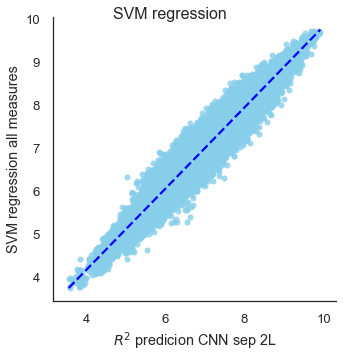

In [80]:
d = df_NM2

snsplot = sns.lmplot(x='CNN_sep_2L', y='New Measure', palette= sns.color_palette("Reds"),data=d, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L','SVM regression all measures')
sns.set(font_scale=1.2)
sns.set_style(style='white')
fig = snsplot.fig 
fig.suptitle("SVM regression ", fontsize=16)
snsplot.savefig('e:/figures/SVM_non_linear.png', dpi=300)